In [1]:


import sys
import shap 
import pickle
import sklearn 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace 



In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results







In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="dd_fix_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [5]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [6]:
configs.specifier = specifier
configs.data_name = data_name



In [7]:

configs.specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

# demo-Fcls-mm:

- Chosen model: **MLP**



https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

## Load Data

In [8]:



dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [9]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report data:
  dyslexia (59770, 7)
  norm (139507, 7)
  risk (26073, 7)
 


In [10]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,1,177.3,531.8,219.0,1,4,10,23,102.0
1,1,10,4,2,200.5,545.2,247.0,1,4,10,23,102.0
2,1,10,4,3,282.7,542.4,261.0,1,4,10,23,102.0
3,1,10,4,4,358.1,545.5,268.0,1,4,10,23,102.0
4,1,10,4,4,392.8,536.3,129.0,1,4,10,23,102.0


In [11]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features, 
    indicators=indicators,
    targets=targets,
)



In [12]:

x_org.head()



,IQ,FIX_Y,Grade_3,FIX_DURATION,FIX_X,Grade_5,Sex_1,Grade_2,Grade_6,Grade_4,Sex_2,Grade_1,Age
0,23,531.8,0,219.0,177.3,0,1,0,0,1,0,0,10
1,23,545.2,0,247.0,200.5,0,1,0,0,1,0,0,10
2,23,542.4,0,261.0,282.7,0,1,0,0,1,0,0,10
3,23,545.5,0,268.0,358.1,0,1,0,0,1,0,0,10
4,23,536.3,0,129.0,392.8,0,1,0,0,1,0,0,10


In [13]:

features = [
    "FIX_X", "FIX_Y", "FIX_DURATION", "Age", "IQ",
    "Sex_1", "Sex_2", 
    "Grade_1", "Grade_2", "Grade_3", "Grade_4", "Grade_5", "Grade_6"
]


x_org = x_org.loc[:, features]

x_org.head()

,FIX_X,FIX_Y,FIX_DURATION,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
0,177.3,531.8,219.0,10,23,1,0,0,0,0,1,0,0
1,200.5,545.2,247.0,10,23,1,0,0,0,0,1,0,0
2,282.7,542.4,261.0,10,23,1,0,0,0,0,1,0,0
3,358.1,545.5,268.0,10,23,1,0,0,0,0,1,0,0
4,392.8,536.3,129.0,10,23,1,0,0,0,0,1,0,0


In [14]:

# for i in range(x_org.Sex_1.values.shape[0]):
#     print(x_org.Sex_1.values[i], x_org.Sex_2.values[i])



In [15]:



y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [16]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [17]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (225350, 13)


In [18]:

data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=to_shuffle,
        n_splits=10
    )



In [19]:

data



defaultdict(collections.defaultdict,
            {'1': defaultdict(list,
                         {'x_train': array([[0.043, 0.503, 0.022, ..., 1.   , 0.   , 0.   ],
                                 [0.06 , 0.537, 0.025, ..., 1.   , 0.   , 0.   ],
                                 [0.121, 0.53 , 0.027, ..., 1.   , 0.   , 0.   ],
                                 ...,
                                 [0.609, 0.579, 0.022, ..., 0.   , 0.   , 0.   ],
                                 [0.528, 0.546, 0.015, ..., 0.   , 0.   , 0.   ],
                                 [0.644, 0.538, 0.019, ..., 0.   , 0.   , 0.   ]]),
                          'x_test': array([[0.237, 0.533, 0.014, ..., 1.   , 0.   , 0.   ],
                                 [0.34 , 0.495, 0.055, ..., 1.   , 0.   , 0.   ],
                                 [0.074, 0.539, 0.025, ..., 1.   , 0.   , 0.   ],
                                 ...,
                                 [0.063, 0.473, 0.008, ..., 0.   , 0.   , 0.   ],
        

## Load the tuned parameters OR weights

In [20]:

# tuned_params = load_a_dict(
#     name=configs.specifier,
#     save_path=configs.params_path
#         )
# tuned_params




# mdl = sklearn.neural_network.MLPClassifier(
#     activation=tuned_params["activation"], 
#     hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
#     max_iter=tuned_params["max_iter"],
#     solver=tuned_params["solver"],
#     verbose=1
# )

# mdl


In [21]:


specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

In [22]:

filename = "mlp_fix_demo_with_iq_01.pickle"
mdl = pickle.load(open(filename, "rb"))

mdl 




MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [23]:


x_train = data["6"]["x_train"]
x_test = data["6"]["x_test"]
y_train = data["6"]["y_train"]
y_test = data["6"]["y_test"]



In [24]:


class_names = ['Control', 'At-risk', 'Dyslexic']



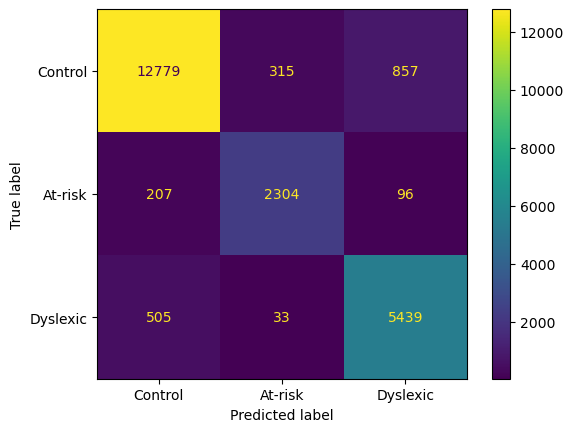

Kappa: 0.8347400437872468 AUC ROC: 0.9825072610728137


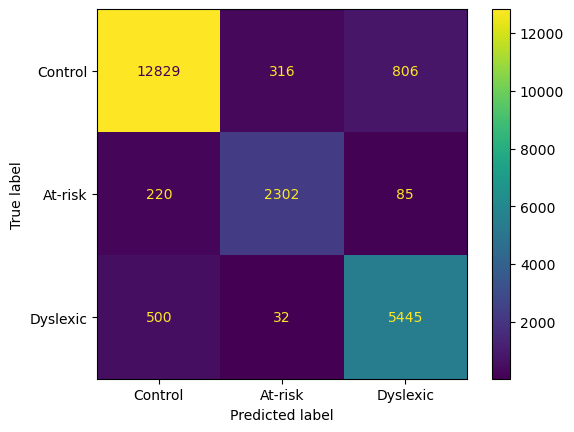

Kappa: 0.8388978522946917 AUC ROC: 0.9829182453627607


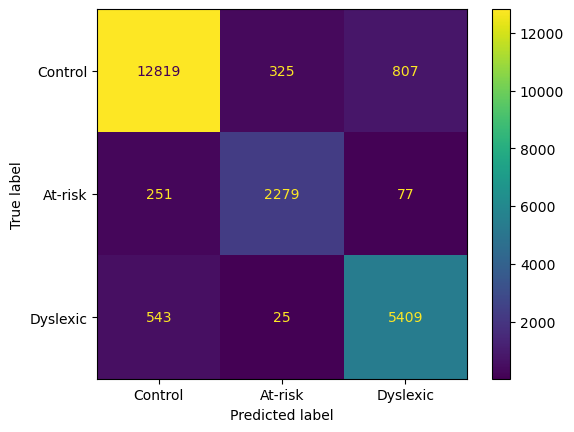

Kappa: 0.832869081391151 AUC ROC: 0.9823166765651608


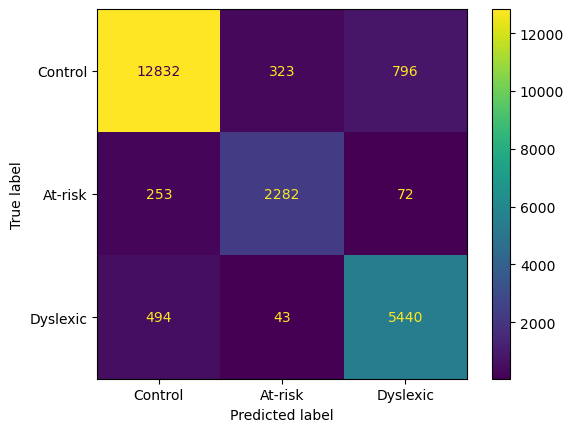

Kappa: 0.8369422822490217 AUC ROC: 0.9828148640073884


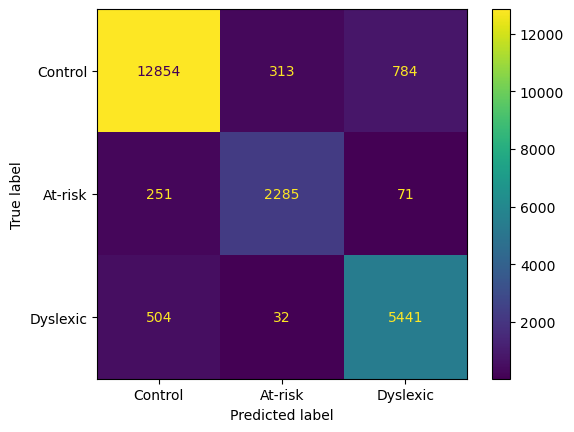

Kappa: 0.8389059114142479 AUC ROC: 0.9829848306845811


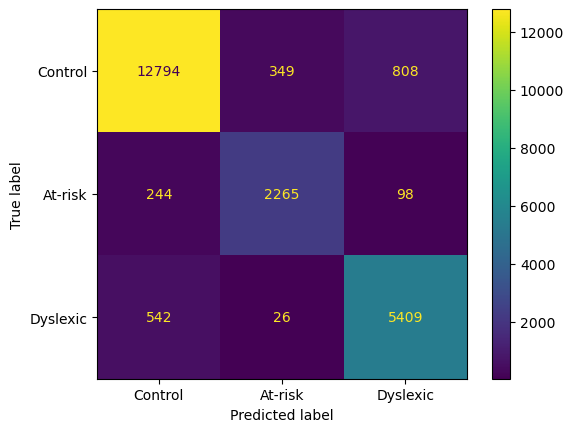

Kappa: 0.829841840423335 AUC ROC: 0.9823257928381303


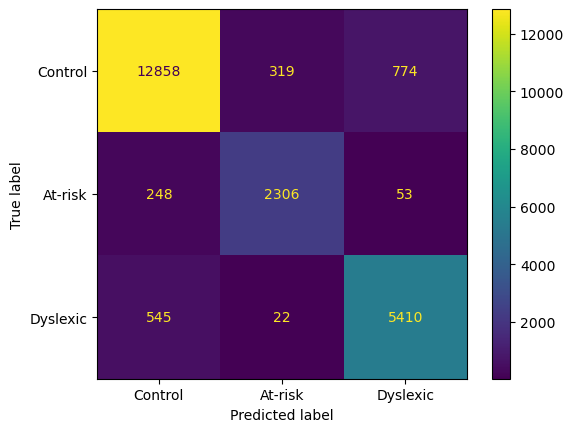

Kappa: 0.8382473045222396 AUC ROC: 0.9827749230027788


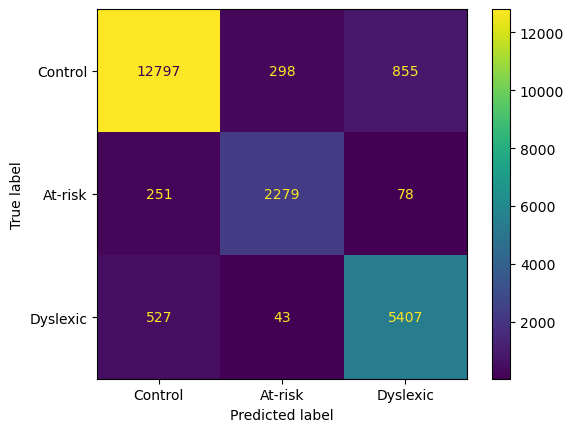

Kappa: 0.8310664313696852 AUC ROC: 0.9821932698756151


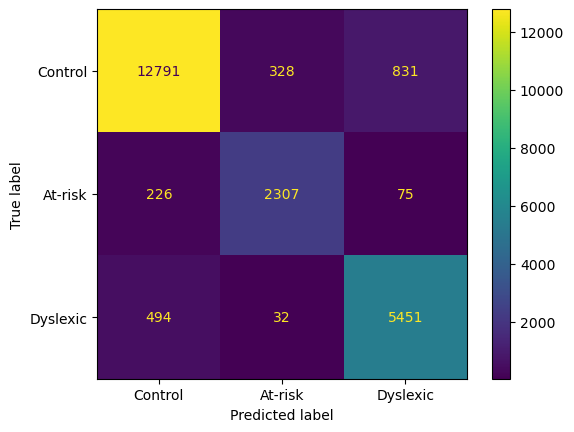

Kappa: 0.8368983636632326 AUC ROC: 0.9830666923198533


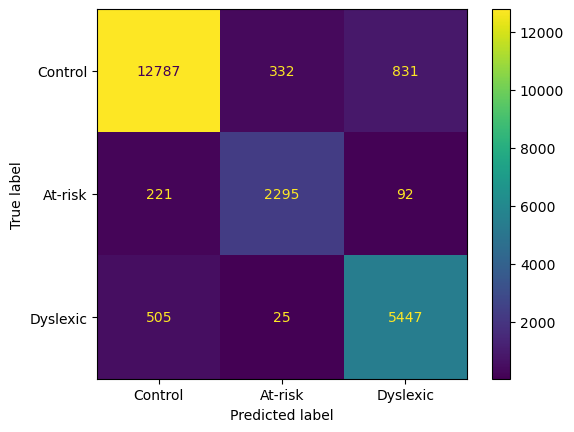

Kappa: 0.8352159256796329 AUC ROC: 0.9824885993933525


In [25]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )




for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    y_prob_ = results[i]["y_pred_prob"]
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
    )
    
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
    disp.plot()
    plt.show()
    
    
    print(
        "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
        "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                  multi_class="ovr",
                                                  average="weighted")
    )





In [26]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)



  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc 	 tnr
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.730 0.004 0.631 0.005 0.913 0.002 0.911 0.002 0.912 0.002 0.983 0.000 1.983 0.012 0.103 0.001 0.911 0.002 0.929 0.002


In [27]:


# mdl.fit(x_train, y_train)




In [28]:

print("model fitted/loaded")


model fitted/loaded


In [29]:



mdl.predict_proba(x_test[5:10:, :])




array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [30]:


mdl.predict(x_test[5:10:, :])



array([1, 1, 1, 1, 1])

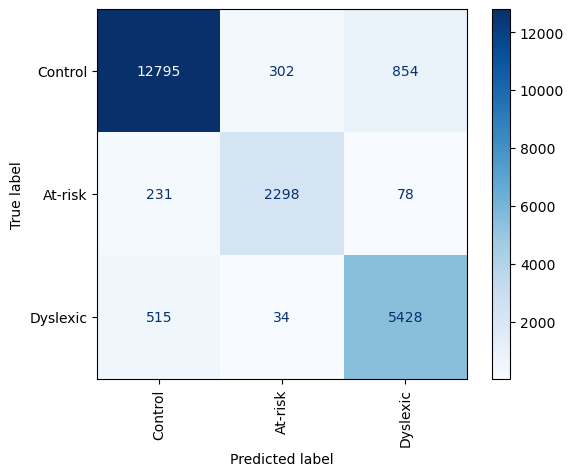

In [31]:


disp = sklearn.metrics.plot_confusion_matrix(
    mdl, x_test, y_test, 
    display_labels=class_names, 
    cmap=plt.cm.Blues, 
    xticks_rotation='vertical'
)




In [32]:

sklearn.metrics.roc_auc_score(y_test, 
                              mdl.predict_proba(x_test),
                              multi_class="ovr",
                              average="weighted")




0.9826165368895433

- 




In [33]:


len(list(x_org.columns)) == x_test.shape[1]




True

In [34]:


# x_test = x_test.astype(dtyp)



In [35]:


x_test.shape



(22535, 13)

In [41]:

background = shap.sample(x_test, 500) # data to train both explainers on



In [42]:


background.shape



(500, 13)

In [ ]:



explainer = shap.KernelExplainer(
    model=mdl.predict_proba, 
    data=background, 
    feature_names=list(x_org.columns), 
    output_names=class_names,
)



shap_values = explainer.shap_values(x_test,)
# shap_values = explainer.shap_values(X_test,)




Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/22535 [00:00<?, ?it/s]

In [ ]:





# explainer = shap.Explainer(
#     model=mdl.predict, 
# #     data=shap.sample(x_train, 2000), 
#     feature_names=list(x_org.columns), 
#     output_names=class_names,
# )



# shap_values = explainer(x_test,)
# # shap_values = explainer.shap_values(X_test,)




In [58]:



print("Shap values are determined!")



Shap values are determined!


In [69]:


len(shap_values)



3

In [70]:


y_test.shape, x_test.shape, len(shap_values), shap_values[0].shape, 



((22535,), (22535, 13), 3, (22535, 13))

- what does row explain?  sorted features' importance in ascending order, low to high.
- what does each dot explain? data points
- what does color explain? data points per feature value

Interpret: 

- 

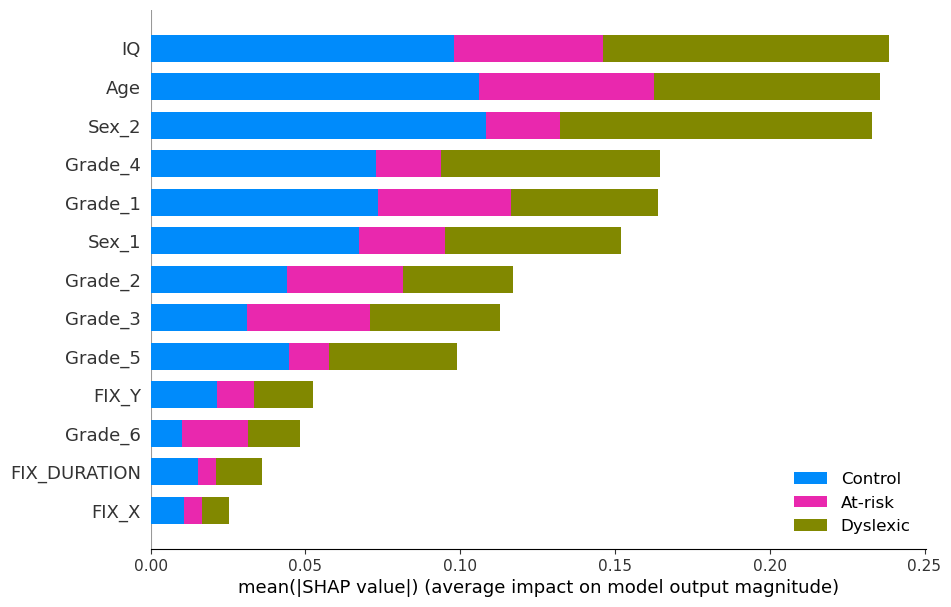

In [61]:



from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

RGB_val = 255

color01= (4,87,172)  # (0,255,255)  # Cyan wanted
color04= (244,230,4)  # (255,255,0)  # yellow wanted
Colors = [color01, color04]

# Creating a blue red palette transition for graphics
Colors= [(R/RGB_val,G/RGB_val,B/RGB_val) for idx, (R,G,B) in enumerate(Colors)]
n = 256

# Start of the creation of the gradient
Color01= ListedColormap(Colors[0], name='Color01', N=None)
Color04= ListedColormap(Colors[1], name='Color04', N=None)
top = cm.get_cmap(Color01,128)
bottom = cm.get_cmap(Color04,128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))

mymin0 = newcolors[0][0]
mymin1 = newcolors[0][1]
mymin2 = newcolors[0][2]
mymin3 = newcolors[0][3]
mymax0 = newcolors[255][0]
mymax1 = newcolors[255][1]
mymax2 = newcolors[255][2]
mymax3 = newcolors[255][3]

GradientBlueRed= [np.linspace(mymin0, mymax0,  n),
                   np.linspace(mymin1, mymax1,  n),
                   np.linspace(mymin2, mymax2,  n),
                   np.linspace(mymin3, mymax3,  n)]

GradientBlueRed_res =np.transpose(GradientBlueRed)

# End of the creation of the gradient

# newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')

# shap.summary_plot(shap_values, x_test, color=newcmp)

# Create colormap
newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')

# Plot the summary without showing it
plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, x_test, 
                  show=False, 
                  plot_size=(10, 7),
                  feature_names=list(x_org.columns), 
                  class_inds="original", 
                  class_names=class_names,
                 )

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)
            
# plt.savefig("summary_fix_demo.png")

           

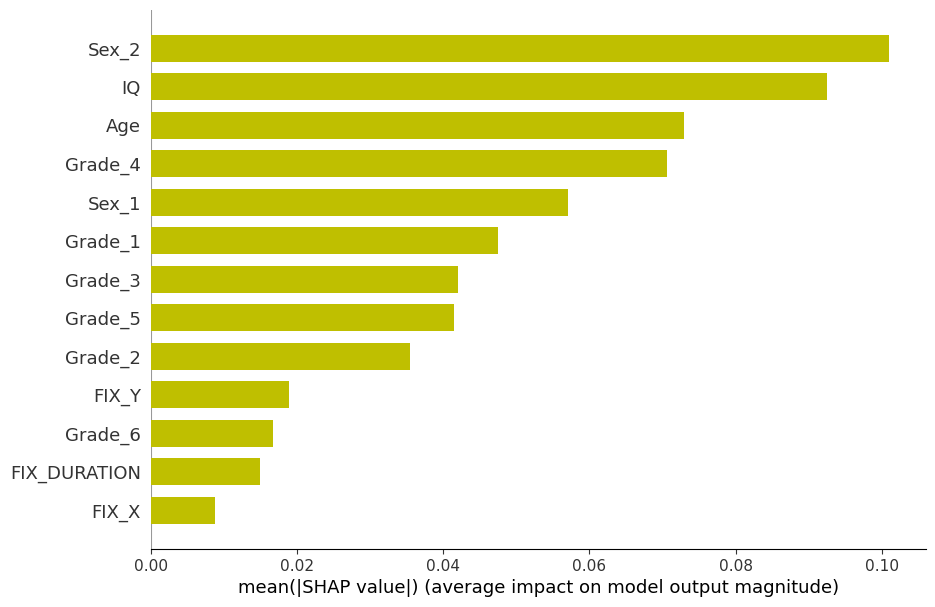

In [234]:
plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values[2], x_test, 
                  show=False, 
                  plot_size=(10, 7),
                  feature_names=list(x_org.columns), 
                  class_inds="original", 
                  class_names=class_names,
                  plot_type="bar",
                  color='y'
                 )


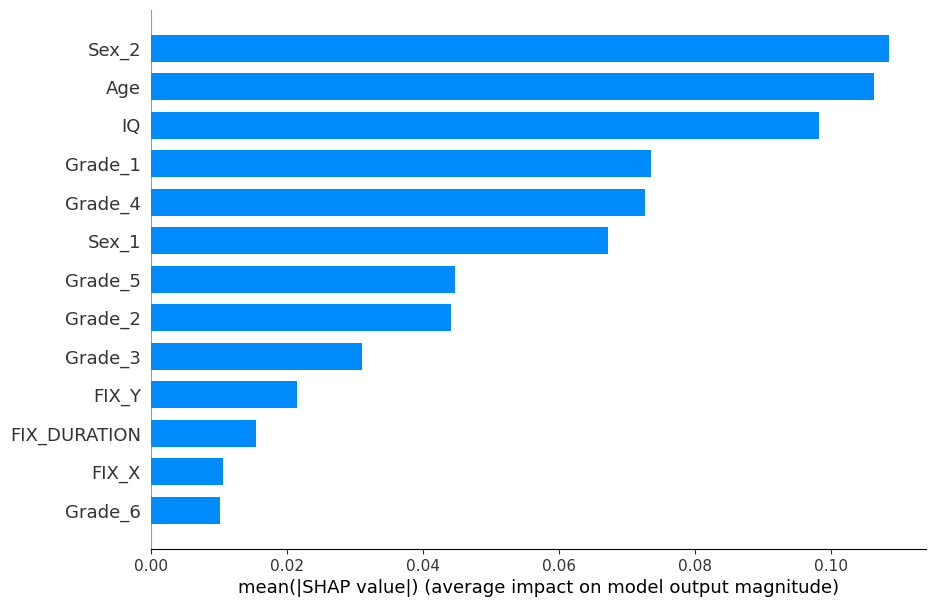

In [230]:
plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values[0], x_test, 
                  show=False, 
                  plot_size=(10, 7),
                  feature_names=list(x_org.columns), 
                  class_inds="original", 
                  class_names=class_names,
                  plot_type="bar"
                 )

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)
            
# plt.savefig("summary_fix_demo.png")

In [152]:
shap_values[0]

array([[-0.001,  0.002, -0.003, ..., -0.028,  0.034, -0.002],
       [-0.004, -0.   ,  0.023, ..., -0.03 ,  0.032, -0.002],
       [-0.003, -0.011,  0.007, ..., -0.025,  0.053, -0.   ],
       ...,
       [-0.026, -0.016, -0.019, ...,  0.062, -0.025, -0.001],
       [-0.029, -0.013,  0.008, ...,  0.018, -0.024, -0.005],
       [-0.008,  0.004,  0.009, ...,  0.07 , -0.018, -0.005]])

In [217]:

mas_per_features = {}
for f in features:
    mas_per_features[f] = []



In [218]:
mas_per_features

{'FIX_X': [],
 'FIX_Y': [],
 'FIX_DURATION': [],
 'Age': [],
 'IQ': [],
 'Sex_1': [],
 'Sex_2': [],
 'Grade_1': [],
 'Grade_2': [],
 'Grade_3': [],
 'Grade_4': [],
 'Grade_5': [],
 'Grade_6': []}

In [219]:


for l in range(len(shap_values)):        
    print(f"Predinting class {l} \n")
    for f in range(len(features)): 
        tmp = np.mean(np.abs(shap_values[l][:, f]), axis=0)
        print(features[f], tmp)
        mas_per_features[features[f]].append(tmp)
    print(" ")
    
    

Predinting class 0 

FIX_X 0.010671871705532495
FIX_Y 0.02143663122262704
FIX_DURATION 0.015426058604461597
Age 0.10617242585633237
IQ 0.09811297537669549
Sex_1 0.06721695522584245
Sex_2 0.10842205503946073
Grade_1 0.07347257551480299
Grade_2 0.0441690740737653
Grade_3 0.031042680749394952
Grade_4 0.07265847130848531
Grade_5 0.04475314046914264
Grade_6 0.010210026054738542
 
Predinting class 1 

FIX_X 0.005869817936177722
FIX_Y 0.011953900047153606
FIX_DURATION 0.0055852987458891775
Age 0.05644000036254313
IQ 0.0478700102191185
Sex_1 0.027692937631605335
Sex_2 0.023785966898773943
Grade_1 0.04277588324721505
Grade_2 0.03732605783070432
Grade_3 0.039692564921116405
Grade_4 0.02117600171023931
Grade_5 0.012878947792031005
Grade_6 0.021273437635326346
 
Predinting class 2 

FIX_X 0.008855575192130745
FIX_Y 0.018937736144578925
FIX_DURATION 0.014892177345619038
Age 0.07287966819575321
IQ 0.09247086367090698
Sex_1 0.057094954321774354
Sex_2 0.10094826137149468
Grade_1 0.047553840735330845
G

In [243]:
A = []
for k, v in mas_per_features.items():
    print(
        f"Sum of MAS of {k} = {np.asarray(v).sum(): .3f}  {np.asarray(v)}"
    )
    A.append(np.asarray(v).sum())
    
    
    

Sum of MAS of FIX_X =  0.025  [0.011 0.006 0.009]
Sum of MAS of FIX_Y =  0.052  [0.021 0.012 0.019]
Sum of MAS of FIX_DURATION =  0.036  [0.015 0.006 0.015]
Sum of MAS of Age =  0.235  [0.106 0.056 0.073]
Sum of MAS of IQ =  0.238  [0.098 0.048 0.092]
Sum of MAS of Sex_1 =  0.152  [0.067 0.028 0.057]
Sum of MAS of Sex_2 =  0.233  [0.108 0.024 0.101]
Sum of MAS of Grade_1 =  0.164  [0.073 0.043 0.048]
Sum of MAS of Grade_2 =  0.117  [0.044 0.037 0.036]
Sum of MAS of Grade_3 =  0.113  [0.031 0.04  0.042]
Sum of MAS of Grade_4 =  0.164  [0.073 0.021 0.071]
Sum of MAS of Grade_5 =  0.099  [0.045 0.013 0.041]
Sum of MAS of Grade_6 =  0.048  [0.01  0.021 0.017]


In [254]:
df_ = sum(A[3:])
fix_ = sum(A[:3])
tot_ = sum(A)
df_, fix_, tot_

(1.564480257857575, 0.11362906694417034, 1.6781093248017454)

In [255]:
A[:3]

[0.025397264833840964, 0.05232826741435957, 0.03590353469596981]

In [256]:
(df_*100)/(tot_)



93.2287446792184

In [257]:
(fix_*100)/(tot_)

6.771255320781599

In [253]:
fix_

0.11362906694417034

In [ ]:
0.025 + 

In [239]:
for k, v in mas_per_features.items():
    print(
        f"Sum of MAS of {k} = {np.asarray(v)} "
    )
    
    

Sum of MAS of FIX_X = [0.011 0.006 0.009] 
Sum of MAS of FIX_Y = [0.021 0.012 0.019] 
Sum of MAS of FIX_DURATION = [0.015 0.006 0.015] 
Sum of MAS of Age = [0.106 0.056 0.073] 
Sum of MAS of IQ = [0.098 0.048 0.092] 
Sum of MAS of Sex_1 = [0.067 0.028 0.057] 
Sum of MAS of Sex_2 = [0.108 0.024 0.101] 
Sum of MAS of Grade_1 = [0.073 0.043 0.048] 
Sum of MAS of Grade_2 = [0.044 0.037 0.036] 
Sum of MAS of Grade_3 = [0.031 0.04  0.042] 
Sum of MAS of Grade_4 = [0.073 0.021 0.071] 
Sum of MAS of Grade_5 = [0.045 0.013 0.041] 
Sum of MAS of Grade_6 = [0.01  0.021 0.017] 


In [216]:


shap_values[0]



array([[-0.001,  0.002, -0.003, ..., -0.028,  0.034, -0.002],
       [-0.004, -0.   ,  0.023, ..., -0.03 ,  0.032, -0.002],
       [-0.003, -0.011,  0.007, ..., -0.025,  0.053, -0.   ],
       ...,
       [-0.026, -0.016, -0.019, ...,  0.062, -0.025, -0.001],
       [-0.029, -0.013,  0.008, ...,  0.018, -0.024, -0.005],
       [-0.008,  0.004,  0.009, ...,  0.07 , -0.018, -0.005]])

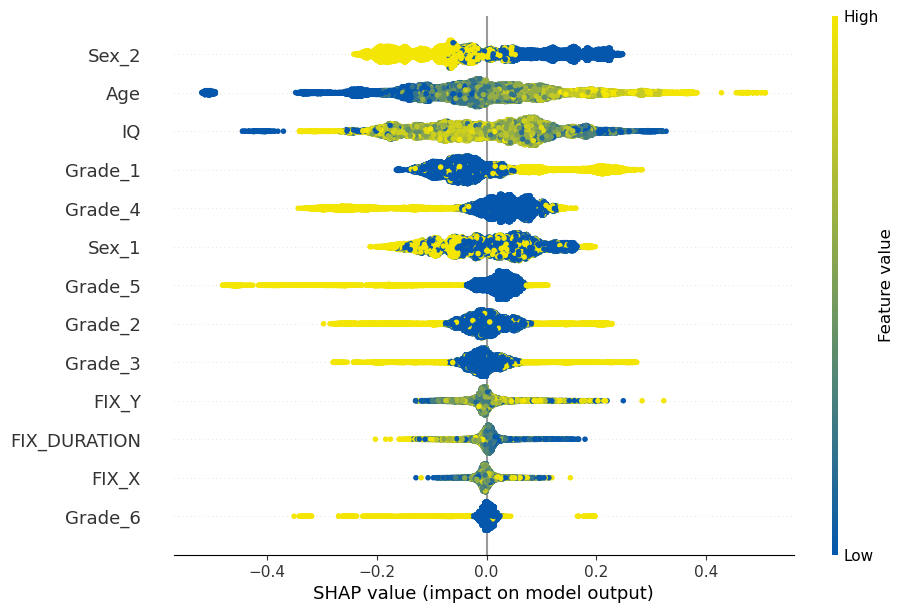

In [235]:



shap.summary_plot(shap_values[0], x_test,
                  show=False, plot_size=(10, 7), 
                  feature_names=list(x_org.columns), 
                  class_inds="original", 
                  class_names=class_names,
                  title=None)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)
# plt.title("Control Group")

plt.show()

            
            

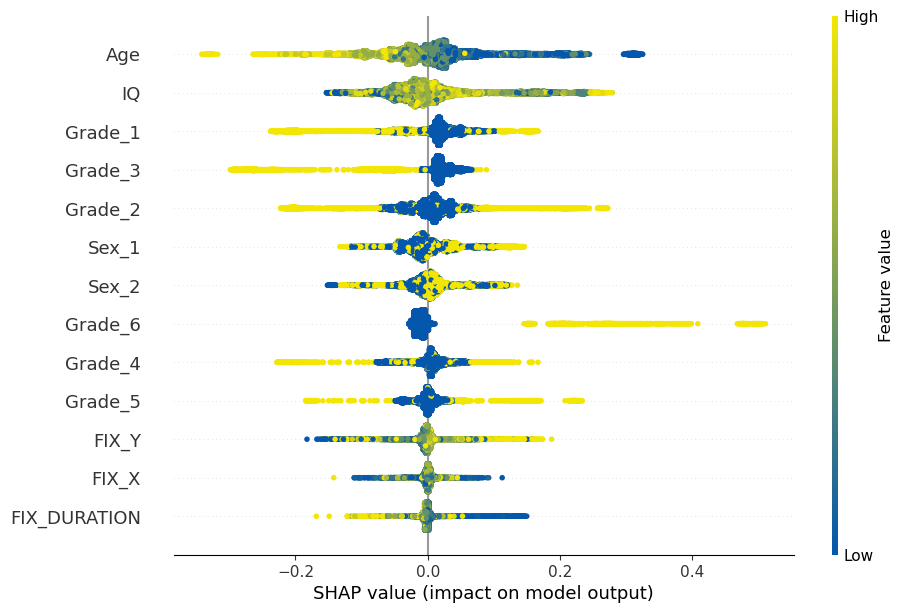

In [236]:




shap.summary_plot(shap_values[1], x_test,
                  show=False, plot_size=(10, 7), 
                  feature_names=list(x_org.columns), 
                  class_inds="original", 
                  class_names=class_names,
                  title=None)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)
# plt.title("At-Risk")

plt.show()

            

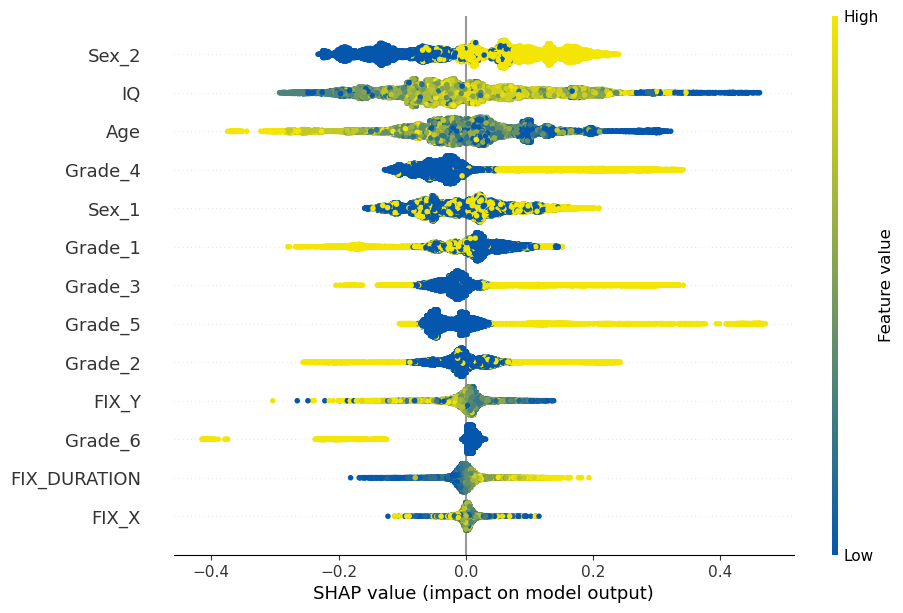

In [237]:




shap.summary_plot(shap_values[2], x_test,
                  show=False, plot_size=(10, 7), 
                  feature_names=list(x_org.columns), 
                  class_inds="original", 
                  class_names=class_names,
                  title=None)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)
            
# plt.title("Dyslexics")

plt.show()



In [93]:


shap_values_mean = np.asarray(shap_values)
shap_values_mean.shape

(3, 22535, 13)

In [94]:
shape_values_mean_ = np.abs(shap_values_mean).mean(axis=0)
shape_values_mean_.shape

(22535, 13)

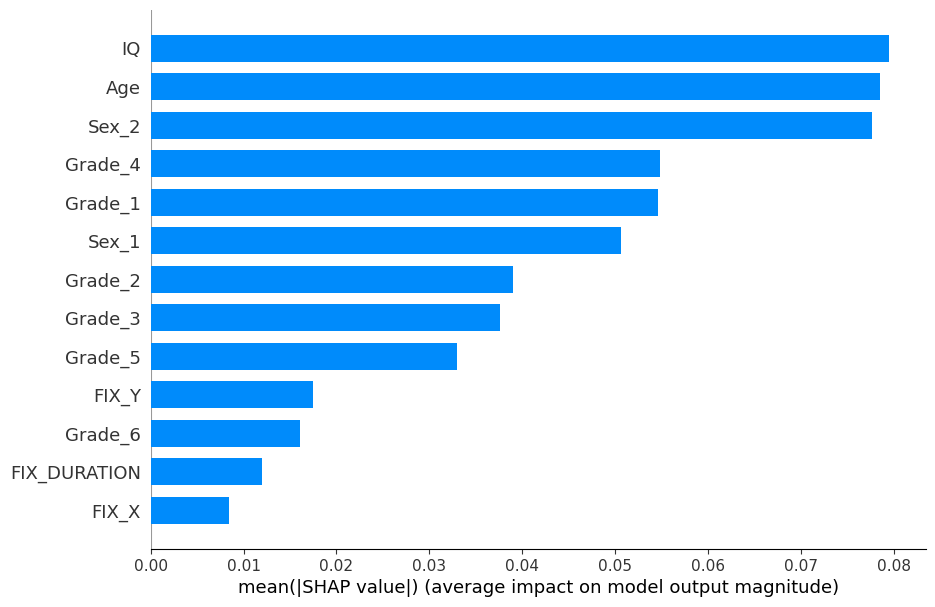

In [98]:



from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

RGB_val = 255

color01= (4,87,172)  # (0,255,255)  # Cyan wanted
color04= (244,230,4)  # (255,255,0)  # yellow wanted
Colors = [color01, color04]

# Creating a blue red palette transition for graphics
Colors= [(R/RGB_val,G/RGB_val,B/RGB_val) for idx, (R,G,B) in enumerate(Colors)]
n = 256

# Start of the creation of the gradient
Color01= ListedColormap(Colors[0], name='Color01', N=None)
Color04= ListedColormap(Colors[1], name='Color04', N=None)
top = cm.get_cmap(Color01,128)
bottom = cm.get_cmap(Color04,128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))

mymin0 = newcolors[0][0]
mymin1 = newcolors[0][1]
mymin2 = newcolors[0][2]
mymin3 = newcolors[0][3]
mymax0 = newcolors[255][0]
mymax1 = newcolors[255][1]
mymax2 = newcolors[255][2]
mymax3 = newcolors[255][3]

GradientBlueRed= [np.linspace(mymin0, mymax0,  n),
                   np.linspace(mymin1, mymax1,  n),
                   np.linspace(mymin2, mymax2,  n),
                   np.linspace(mymin3, mymax3,  n)]

GradientBlueRed_res =np.transpose(GradientBlueRed)

# End of the creation of the gradient

# newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')

# shap.summary_plot(shap_values, x_test, color=newcmp)

# Create colormap
newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')

# Plot the summary without showing it
plt.figure(figsize=(10, 7))
shap.summary_plot(shape_values_mean_, x_test, 
                  show=False, 
                  plot_size=(10, 7),
                  feature_names=list(x_org.columns), 
                  class_inds="original", 
                  class_names=class_names,
                  plot_type="bar"
                      
                 )

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)
            
# plt.savefig("summary_fix_demo.png")

           

In [1]:


# shap.bar_plot(shape_values_mean_, 
#               x_test, 
# #                   show=False, 
# #                   plot_size=(10, 7),
#                   feature_names=list(x_org.columns), 
# #                   class_inds="original", 
# #                   class_names=class_names,
# #                   plot_type="bar"
                      
#                  )

